In [1]:
import os
import math
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry import LineString, Polygon  
import geopandas as gpd


In [2]:
df = pd.read_csv('/glade/p/cisl/aiml/conv_risk_intel/ncei_tornado_tracks/1950-2019_ncei_tornadoes.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print(df.columns)


Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'tor length (miles)', 'tor width (feet)', 'TOR_OTHER_WFO',
       'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
       'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'begin_datetime_UTC', 'end_datetime_UTC', 'duration (minutes)',
       'speed (mph)', 'mag'],
      dtype='object')


/glade/work/ggantos/miniconda2/envs/holo_torch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
'/glade/p/cisl/aiml/conv_risk_intel/ncei_tornado_tracks/1950-2019_ncei_tornadoes.csv'

'/glade/p/cisl/aiml/conv_risk_intel/ncei_tornado_tracks/1950-2019_ncei_tornadoes.csv'

In [3]:
df['EPISODE_ID']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
70274   NaN
70275   NaN
70276   NaN
70277   NaN
70278   NaN
Name: EPISODE_ID, Length: 70279, dtype: float64

In [3]:
date = '20110612'
hour = 0
ds = xr.open_dataset(os.path.join("/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc/", date, f"ruc2anl_130_{date}_{hour:02d}00_000.nc"))


In [4]:
proj = Proj(proj='lcc', R=6371229, lat_0=25, lon_0=265, lat_1=25, lat_2=25)


In [5]:
df[['BEGIN_LON_M', 'BEGIN_LAT_M']] = np.array(proj(list(df['BEGIN_LON']), list(df['BEGIN_LAT']))).T
df[['END_LON_M', 'END_LAT_M']] = np.array(proj(list(df['END_LON']), list(df['END_LAT']))).T


In [6]:
df['EPISODE_ID']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
70274   NaN
70275   NaN
70276   NaN
70277   NaN
70278   NaN
Name: EPISODE_ID, Length: 70279, dtype: float64

In [13]:
line = LineString([lonlat_begin[1], lonlat_end[1]])
left_hand_side = line.buffer(df['tor width (feet)'][1] * 0.3048)
print(left_hand_side.minimum_rotated_rectangle)


POLYGON ((330000.4955122719 1508716.813028557, 337858.9486516685 1516960.662183482, 337845.7113667906 1516973.280631606, 329987.258227394 1508729.431476681, 330000.4955122719 1508716.813028557))


In [55]:
type(left_hand_side)

shapely.geometry.polygon.Polygon

In [56]:
type(left_hand_side.minimum_rotated_rectangle)

shapely.geometry.polygon.Polygon

In [64]:
x,y = left_hand_side.minimum_rotated_rectangle.exterior.coords.xy
print(x)
print(y)

array('d', [330000.4955122719, 337858.9486516685, 337845.7113667906, 329987.25822739396, 330000.4955122719])
array('d', [1508716.8130285565, 1516960.6621834822, 1516973.2806316065, 1508729.4314766808, 1508716.8130285565])


In [63]:
print(df['BEGIN_LON_M'][1], df['BEGIN_LAT_M'][1])

330000.1860938951 1508729.7408950576


In [ ]:

x, y = some_poly.exterior.coords.xy


In [71]:


end_lon, end_lat = left_hand_side.minimum_rotated_rectangle.exterior.coords.xy
rectangle = np.array(proj(end_lon, end_lat, inverse=True)).T
rectangle = Polygon(rectangle)


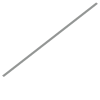

In [72]:
rectangle

In [67]:
def getEndpoint(d, begin_lon, begin_lat):
    
    d = d / 0.62137 #Convert d to km from miles
    R = 6371.229 #Radius of the Earth 
    brng = 45 * math.pi/180 #Bearing is 45 degrees converted to radians.

    begin_lon = math.radians(begin_lon)
    begin_lat = math.radians(begin_lat)

    end_lat = math.asin(math.sin(begin_lat)*math.cos(d/R) +
                        math.cos(begin_lat)*math.sin(d/R)*math.cos(brng))
    
    end_lon = begin_lon + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(begin_lat),
                                math.cos(d/R)-math.sin(begin_lat)*math.sin(end_lat))
    
    end_lat = math.degrees(end_lat)
    end_lon = math.degrees(end_lon)
    
    return end_lon, end_lat


In [83]:
for index, row in df.iterrows():
    if index % 10000 == 0:
        print(f"Finished with {index} rows")
    if np.isinf(row['BEGIN_LON_M']):
        print(f" - No begin lat lon at index {index}")
        continue
    if pd.isna(row['END_LON']):
        end_lon, end_lat = getEndpoint(row['tor length (miles)'], row['BEGIN_LON'], row['BEGIN_LAT'])
        end_lon, end_lat = np.array(proj(end_lon, end_lat)).T
        line = LineString([[row['BEGIN_LON_M'], row['BEGIN_LAT_M']],
                           [end_lon, end_lat]])
        rectangle = line.buffer(row['tor width (feet)'] * 0.3048)        
    else:
        line = LineString([[row['BEGIN_LON_M'], row['BEGIN_LAT_M']],
                           [row['END_LON_M'], row['END_LAT_M']]])
        rectangle = line.buffer(row['tor width (feet)'] * 0.3048)
    end_lon, end_lat = rectangle.minimum_rotated_rectangle.exterior.coords.xy
    rectangle = Polygon(np.array(proj(end_lon, end_lat, inverse=True)).T)
    df.at[index, "track_rectangle"] = rectangle


Finished with 0 rows
Finished with 10000 rows
Finished with 20000 rows
Finished with 30000 rows
Finished with 40000 rows
Finished with 50000 rows
Finished with 60000 rows
Finished with 70000 rows


In [93]:
gdf = gpd.GeoDataFrame(df, geometry="track_rectangle")
gdf.to_file("./2019_ncei_tornadoes_rectangles_v1.geojson", driver='GeoJSON')
"/glade/work/ggantos/tornado_jtti/scripts/2019_ncei_tornadoes_rectangles_v1.geojson"
